In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
gc.collect()

%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reduce the memory usage - by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

### Transactions

In [4]:
transactions = reduce_mem_usage(pd.read_csv('historical_transactions.csv'))
gc.collect()

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


0

In [5]:
transactions.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

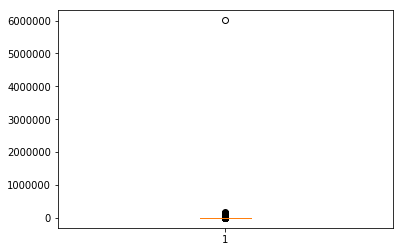

In [17]:
# Boxplot
plt.boxplot(transactions.purchase_amount)
plt.show()

In [18]:
len(transactions.loc[transactions.purchase_amount > 100,].purchase_amount)

1183

In [19]:
# transactions = transactions.loc[transactions.purchase_amount < 100000,]
# plt.boxplot(transactions.purchase_amount)
# plt.show()

In [21]:
mask = transactions.installments == 999
column_name = 'installments'
transactions.loc[mask, column_name] = -1 ### 999 có vẻ là NA

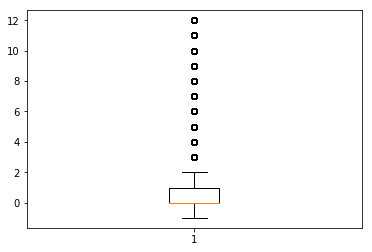

In [23]:
# Boxplot for installments
plt.boxplot(transactions.installments)
plt.show();

# Remove the outlier at 1000 installments
# transactions = transactions.loc[transactions.installments < 200,]

In [24]:
transactions["merchant_id"] = transactions.groupby(["card_id"])["merchant_id"].transform(lambda x: x.fillna(x.mode()[0]))
gc.collect()

7

In [25]:
cate3 = transactions.loc[:, transactions.columns != 'category_2']

In [26]:
cols = ['card_id', 'city_id', 'category_1', 'installments','merchant_category_id','merchant_id',
       'state_id','subsector_id']
label_enc = LabelEncoder()
for c in cols:
    label_enc.fit(list(cate3[c].values)) 
    cate3[c] = label_enc.transform(list(cate3[c].values))

In [27]:
cate3 = cate3.drop(['purchase_date'], axis = 1)
train = cate3.dropna()
test = cate3.loc[cate3.category_3.isnull()]
test = test.reset_index()
train = train.reset_index()
test = test.drop('index', axis = 1)
train = train.drop('index', axis = 1)
gc.collect()

55

In [28]:
train['category_3'] = train['category_3'].map({'A':0, 'B':1, 'C':2})
y_train = train.category_3.values
train = train.drop(['authorized_flag','category_3'], axis = 1)
test = test.drop(['authorized_flag','category_3'], axis = 1)
gc.collect()

41

In [29]:
RF = RandomForestClassifier()
RFMd = RF.fit(train, y_train)
y_pred = RFMd.predict(test)

In [30]:
fill = pd.DataFrame(index = cate3.index[cate3.isnull().any(axis=1)], data= y_pred, columns=['category_3'])
cate3 = cate3.fillna(fill)
gc.collect()

7

In [31]:
cate3.category_3.isnull().sum()

0

In [32]:
cate3['category_3'] = cate3['category_3'].map({0: 0, 1 : 1, 2 : 2, 'A': 0, 'B': 1, 'C': 2})
gc.collect()

47

In [33]:
cate3['category_2'] = transactions['category_2']

In [34]:
train = cate3.dropna()
test = cate3.loc[cate3.category_2.isnull()]
test = test.reset_index()
train = train.reset_index()
test = test.drop('index', axis = 1)
train = train.drop('index', axis = 1)
gc.collect()

89

In [35]:
y_train = train.category_2.values
train = train.drop(['authorized_flag','category_2'], axis = 1)
test = test.drop(['authorized_flag','category_2'], axis = 1)

In [36]:
RF = RandomForestClassifier()
RFMd = RF.fit(train, y_train)
y_pred = RFMd.predict(test)

In [37]:
cate3.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3                    0
merchant_category_id          0
merchant_id                   0
month_lag                     0
purchase_amount               0
state_id                      0
subsector_id                  0
category_2              2652864
dtype: int64

In [38]:
transactions['category_2'] = cate3['category_2']
transactions['category_3'] = cate3['category_3']

In [39]:
del cate3

In [40]:
fill = pd.DataFrame(index = transactions.index[transactions.isnull().any(axis=1)], data= y_pred, columns=['category_2'])
transactions = transactions.fillna(fill)

In [41]:
transactions.isnull().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [42]:
transactions.to_csv('historical_transactions_clean_outlier.csv')

In [43]:
del transactions

### Merchants

In [61]:
merchants = reduce_mem_usage(pd.read_csv('merchants.csv'))

Mem. usage decreased to 30.32 Mb (46.0% reduction)


In [62]:
merchants.isnull().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [63]:
# Drop rows with missing values of lagged sales
merchants.dropna(subset=['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12'], axis=0, inplace=True)

In [64]:
merchants = merchants.drop_duplicates(subset = ['merchant_id'])

In [65]:
merchants = merchants.reset_index()
merchants = merchants.drop('index', axis = 1)
temp = merchants
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_c929bb59af,9514,2,20,-0.057465,-0.057465,N,E,E,69667.000000,...,69667.000000,1.000000,3,69667.000000,1.000000,3,N,-1,20,5.0
4,M_ID_dd3ae3de10,30534,278,37,-0.057465,-0.057465,N,E,E,5180.000000,...,9830.000000,4.166667,6,15826.000000,5.600000,10,Y,11,23,2.0


In [66]:
cols = ['merchant_group_id', 'merchant_category_id', 'subsector_id', 'category_1','most_recent_sales_range',
        'most_recent_purchases_range', 'state_id','city_id', 'category_4']
label_enc = LabelEncoder()
for c in cols:
    label_enc.fit(list(merchants[c].values)) 
    merchants[c] = label_enc.transform(list(merchants[c].values))

In [67]:
train = merchants.dropna()
test = merchants.loc[merchants.category_2.isnull()]
test = test.reset_index()
train = train.reset_index()
test = test.drop('index', axis = 1)
train = train.drop('index', axis = 1)

In [68]:
test_merchant_id = test.merchant_id
y_train = train.category_2.values
train = train.drop(['merchant_id','category_2'], axis = 1)
test = test.drop(['merchant_id','category_2'], axis = 1)

In [69]:
Xtree = ExtraTreesClassifier()
XtreeMd = Xtree.fit(train, y_train)
y_pred = Xtree.predict(test)

In [70]:
fill = pd.DataFrame(index = temp.index[temp.isnull().any(axis=1)], data= y_pred, columns=['category_2'])
temp = temp.fillna(fill)

In [71]:
temp.category_2.value_counts()

1.0    160855
3.0     62159
5.0     54354
4.0     36442
2.0     20810
Name: category_2, dtype: int64

In [72]:
temp.isnull().sum()

merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
dtype: int64

In [73]:
temp.to_csv('merchants_clean.csv')

### New_transactions

In [44]:
new_transactions = reduce_mem_usage(pd.read_csv('new_merchant_transactions.csv'))

Mem. usage decreased to 114.20 Mb (45.5% reduction)


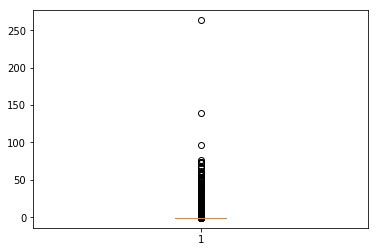

In [45]:
# Boxplot
plt.boxplot(new_transactions.purchase_amount)
plt.show()

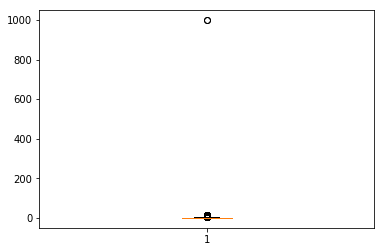

In [46]:
plt.boxplot(new_transactions.installments)
plt.show()

In [48]:
mask = new_transactions.installments == 999
column_name = 'installments'
new_transactions.loc[mask, column_name] = -1

In [ ]:
# Similarly to historical transactions, we remove outliers for the purchase amount and installments
# new_transactions = new_transactions.loc[(new_transactions.purchase_amount < 100000) & (new_transactions.installments < 900),]

In [65]:
new_transactions["merchant_id"] = new_transactions.groupby(["card_id","merchant_category_id"])["merchant_id"].transform(lambda x: x.fillna(x.mode()[0]) if len(x.mode()) > 0 else  x.fillna(float('NaN')))

In [66]:
new_transactions["merchant_id"] = new_transactions.groupby(["card_id"])["merchant_id"].transform(lambda x: x.fillna(x.mode()[0]) if len(x.mode()) > 0 else  x.fillna(float('NaN')))

In [67]:
new_transactions["merchant_id"] = new_transactions.groupby(["merchant_category_id"])["merchant_id"].transform(lambda x: x.fillna(x.mode()[0]) if len(x.mode()) > 0 else  x.fillna(float('NaN')))

In [68]:
cate3 = new_transactions.loc[:, new_transactions.columns != 'category_2']

In [69]:
cols = ['card_id', 'city_id', 'category_1', 'installments','merchant_category_id','merchant_id',
       'state_id','subsector_id']
label_enc = LabelEncoder()
for c in cols:
    label_enc.fit(list(cate3[c].values)) 
    cate3[c] = label_enc.transform(list(cate3[c].values))

In [70]:
cate3 = cate3.drop(['purchase_date'], axis = 1)
train = cate3.dropna()
test = cate3.loc[cate3.category_3.isnull()]
test = test.reset_index()
train = train.reset_index()
test = test.drop('index', axis = 1)
train = train.drop('index', axis = 1)

In [71]:
train['category_3'] = train['category_3'].map({'A':0, 'B':1, 'C':2})
y_train = train.category_3.values
train = train.drop(['authorized_flag','category_3'], axis = 1)
test = test.drop(['authorized_flag','category_3'], axis = 1)

In [72]:
models = [RandomForestClassifier(),ExtraTreesClassifier()]
names = ["RF", "Xtree"]
dict_score = {}
for name, model in zip(names, models):
    model.fit(train, y_train)
    model_train_pred = model.predict(train)
    accy = round(accuracy_score(y_train, model_train_pred), 6)
    dict_score[name] = accy

import operator
dict_score = sorted(dict_score.items(), key = operator.itemgetter(1), reverse = True)
dict_score

[('RF', 1.0), ('Xtree', 1.0)]

In [73]:
RF = RandomForestClassifier()
RFMd = RF.fit(train, y_train)
y_pred = RFMd.predict(test)

In [74]:
cate3.isnull().sum()

authorized_flag             0
card_id                     0
city_id                     0
category_1                  0
installments                0
category_3              55922
merchant_category_id        0
merchant_id                 0
month_lag                   0
purchase_amount             0
state_id                    0
subsector_id                0
dtype: int64

In [75]:
fill = pd.DataFrame(index = cate3.index[cate3.isnull().any(axis=1)], data= y_pred, columns=['category_3'])
cate3 = cate3.fillna(fill)

In [76]:
cate3.category_3.isnull().sum()

0

In [77]:
cate3['category_3'] = cate3['category_3'].map({0: 0, 1 : 1, 2 : 2, 'A': 0, 'B': 1, 'C': 2})

In [78]:
cate3['category_2'] = new_transactions['category_2']

In [79]:
train = cate3.dropna()
test = cate3.loc[cate3.category_2.isnull()]
test = test.reset_index()
train = train.reset_index()
test = test.drop('index', axis = 1)
train = train.drop('index', axis = 1)

In [80]:
y_train = train.category_2.values
train = train.drop(['authorized_flag','category_2'], axis = 1)
test = test.drop(['authorized_flag','category_2'], axis = 1)

In [81]:
models = [RandomForestClassifier(),ExtraTreesClassifier()]
names = ["RF", "Xtree"]
dict_score = {}
for name, model in zip(names, models):
    model.fit(train, y_train)
    model_train_pred = model.predict(train)
    accy = round(accuracy_score(y_train, model_train_pred), 6)
    dict_score[name] = accy

import operator
dict_score = sorted(dict_score.items(), key = operator.itemgetter(1), reverse = True)
dict_score

[('RF', 1.0), ('Xtree', 1.0)]

In [82]:
RF = RandomForestClassifier()
RFMd = RF.fit(train, y_train)
y_pred = RFMd.predict(test)

In [83]:
fill = pd.DataFrame(index = cate3.index[cate3.isnull().any(axis=1)], data= y_pred, columns=['category_2'])
cate3 = cate3.fillna(fill)

In [84]:
new_transactions['category_2'] = cate3['category_2']
new_transactions['category_3'] = cate3['category_3']

In [85]:
new_transactions.isnull().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

In [86]:
new_transactions.to_csv('new_merchant_transactions_clean_outlier.csv')